# Traffic Congestion Control System - Phase 1: Vehicle Detection

 Traffic congestion is a major issue in urban areas, leading to increased travel time, fuel consumption, and environmental pollution. Current traffic control systems often rely on fixed time-based signals that fail to adapt dynamically to varying traffic conditions. There is a pressing need for an intelligent system that can accurately detect the number and type of vehicles on the road, enabling real-time traffic management to optimize traffic flow and reduce congestion.

Objective:The first phase of this project focuses on developing a machine learning-based model for vehicle detection. The goal is to create a robust system capable of identifying vehicles in real-time from traffic camera feeds or recorded videos. This model will serve as the foundation for implementing dynamic traffic control strategies in later phases.

# Importing all libraries

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os

from copy import deepcopy
from sklearn.preprocessing import LabelEncoder

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, vgg16, mobilenet_v2

import torch.nn as nn
import torch.nn.functional as F

# Downloading and creating dataset

The dataset consists of 2000 high-resolution images of 10 different classes.
- SUV
- Bus
- Family Sedan
- Fire Engine
- Heavy Truck
- Jeep
- Minibus
- Racing Car
- Taxi
- Truck

The dataset was downloaded from kaggle and here is the [Dataset Link](https://www.kaggle.com/datasets/marquis03/vehicle-classification)

# Download the dataset

In [2]:
import kagglehub

# Download the dataset
base_dir = kagglehub.dataset_download("marquis03/vehicle-classification")
print(f"{base_dir = }")

base_dir = '/kaggle/input/vehicle-classification'


# List Dataset Contents
This cell retrieves and displays the contents of the specified dataset directory (base_dir) to inspect its structure.



In [3]:
dataset = os.listdir(base_dir)
dataset

['val', 'test', 'train']


This function `create_df`, generates a pandas DataFrame containing image file paths, and optionally their associated labels, based on the structure of a directory.

### Outputs
- `Images` and `Labels` (if `labeled=True`)
- `Images` only (if `labeled=False`)

# Dataset Preparation - Creating a DataFrame of Image Paths and Labels
Description:
This code defines the create_df function, which is used to prepare a dataset by creating a pandas DataFrame. The function processes the directory structure to extract paths to images and their corresponding labels (if labeled).

In [4]:
def create_df(base_dir, labeled=True):
    if labeled:
        dd = {"images": [], "labels": []}
        for i in os.listdir(base_dir):
            img_dirs = os.path.join(base_dir, i)
            for j in os.listdir(img_dirs):
                img = os.path.join(img_dirs, j)
                dd["images"] += [img]
                dd["labels"] += [i]

    else:
        dd = {"images": []}
        for i in os.listdir(base_dir):
            img_dirs = os.path.join(base_dir, i)
            dd["images"] += [img_dirs]

    return pd.DataFrame(dd)

#  Create DataFrames for Train, Validation, and Test Datasets
This cell utilizes the create_df function to construct pandas DataFrames for the training, validation, and test datasets. These DataFrames organize image paths and labels for easy access and preprocessing.

In [5]:
train = create_df(os.path.join(base_dir, "train"))
val = create_df(os.path.join(base_dir, "val"))
test = create_df(os.path.join(base_dir, "test"), False)

# Inspect Training DataFrame Structure
This cell prints the structure and summary information of the train DataFrame, which contains the training dataset's image paths and labels.



In [6]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  1400 non-null   object
 1   labels  1400 non-null   object
dtypes: object(2)
memory usage: 22.0+ KB
None


`LabelEncoder()` ensures that the categorical labels in the dataset is encoded as consistent numerical values, which is often required for machine learning models that work with numerical data.

# Label Encoding for Categorical Class Labels
This cell uses LabelEncoder from sklearn.preprocessing to convert categorical class labels in the training and validation datasets into numerical values required for machine learning models.

In [7]:
le = LabelEncoder()
train["labels"] = le.fit_transform(train.loc[:, "labels"].values)
val["labels"] = le.transform(val.loc[:, "labels"].values)

In [8]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  1400 non-null   object
 1   labels  1400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.0+ KB
None


# Define Hyperparameters and Constants
This section defines hyperparameters and constants for the machine learning training process. These values influence the model's training behavior, data handling, and learning rate adjustments.



In [9]:
# Constants

MAX_EPOCHS = 20
LR = 1e-5
BATCH_SIZE = 32
IM_SIZE= 224
STEP = 5
GAMMA = 0.2
DECAY = 0.9
NUM_CLASSES = train["labels"].nunique()

This block defines a transformation pipeline using PyTorch's transforms module.The transformations are applied to preprocess images before feeding them into a machine learning model.

**Transformation Pipeline:**

1. `transforms.ToPILImage():` Converts the input image (in NumPy format) to a PIL Image.
2. `transforms.ToTensor():` Converts the PIL Image to a PyTorch tensor, scaling pixel values to the range [0, 1].
3. `transforms.Resize((IM_SIZE, IM_SIZE)):` Resizes the image to the specified dimensions (IM_SIZE x IM_SIZE).

# Data Augmentation and Preprocessing for Training and Validation
This cell defines data augmentation and preprocessing pipelines for both the training and validation datasets using torchvision.transforms. These transformations are applied to the images to prepare them for input into the model.

In [10]:
train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

`ImageDataset` defines a custom PyTorch dataset class, designed to handle image data and their corresponding labels. It simplifies loading and preprocessing images for training machine learning models.

# Custom PyTorch Dataset Class for Image and Label Handling
This cell defines a custom PyTorch Dataset class, ImageDataset, to handle loading and preprocessing images along with their corresponding labels. It is a crucial step in creating an efficient data pipeline for training and validation.

In [11]:
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, -1]

        # Load image
        image = Image.open(image_path).convert('RGB')
        
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label

# Create Dataset Objects for Training, Validation, and Testing
This cell creates instances of the ImageDataset class for the training, validation, and testing datasets, integrating the respective data transformations for preprocessing.

In [12]:
train_ds = ImageDataset(train, train_transform)
val_ds = ImageDataset(val, val_transform)
test_ds = ImageDataset(test)

# Display an Image from the Test Dataset
This cell visualizes an image from the test dataset (test_ds) using Matplotlib's imshow function.



(-0.5, 889.5, 710.5, -0.5)

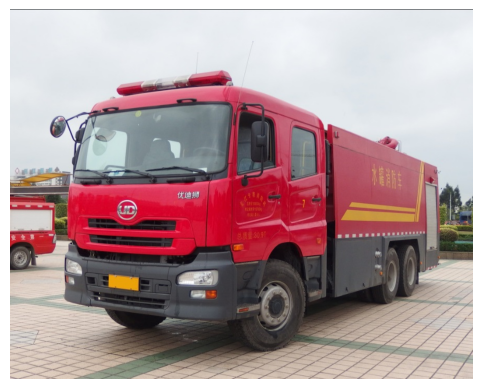

In [13]:
plt.imshow(test_ds[1][0]) # test_ds[idx][0:images]
plt.axis("off")

#  Inspecting Image Dimensions and Pixel Values
This cell prints the length of a specific dimension of an image tensor from the training dataset and displays its transformed pixel values for debugging and analysis.

In [14]:
print(f"{len(train_ds[0][0][0][0]) = }")
print()
print(train_ds[0][0][0][0])
# train[idx][0:image, 1:label][Channel: RGB][transformed pixel values of nth row][nth column]

len(train_ds[0][0][0][0]) = 224

tensor([-2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
        -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,  1.5639,  1.4612,
         1.2557,  1.0673,  0.9132,  0.8276,  0.7419,  0.7419,  0.6906,  0.6563,
         0.6049,  0.5536,  0.2282, -0.1828,  0.2453,  0.0398, -0.1143, -0.3369,
        -0.5767, -0.7137, -0.8849, -0.9363, -0.9363, -1.2445, -1.3987, -1.4329,
        -1.4329, -1.4329, -1.4672, -1.4500, -1.4158, -1.4329, -1.4672, -1.5014,
        -1.5185, -1.5357, -1.5357, -1.5870, -1.6555, -1.6555, -1.6042, -1.5699,
        -1.5357, -1.5528, -1.5357, -1.5357, -1.5357, -1.5014, -1.4843, -1.5014,
        -1.4843, -1.4672, -1.4500, -1.4500, -1.4500, -1.4500, -1.4500, -1.4672,
        -1.4672, -1.4672, -1.4672, -1.4843, -1.5014, -1.5357, -1.5699, -1.4843,
        -1.5014, -1.5185, -1.5357, -1.5699, -1.5357, -1.5357, -1.5528, -1.4500,
        -1.4500, -1.4843, -1.5014, -1.5185, -1.5357, -1.5357, -1.4500, -1.5014,
       

# Check the Shape of a Transformed Image Tensor
This cell prints the shape of a transformed image tensor from the training dataset to confirm its dimensions after preprocessing.

In [15]:
print(np.array(train_ds[0][0]).shape)

(3, 224, 224)


# Create DataLoaders for Training and Validation
This cell creates PyTorch DataLoader objects for the training and validation datasets, enabling efficient batching, shuffling, and parallel data loading.

In [16]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# Visualize a Batch of Training Images with Labels
This cell retrieves a batch of images and their corresponding labels from the training DataLoader, reshapes the images for visualization, and displays them in a grid using Matplotlib.

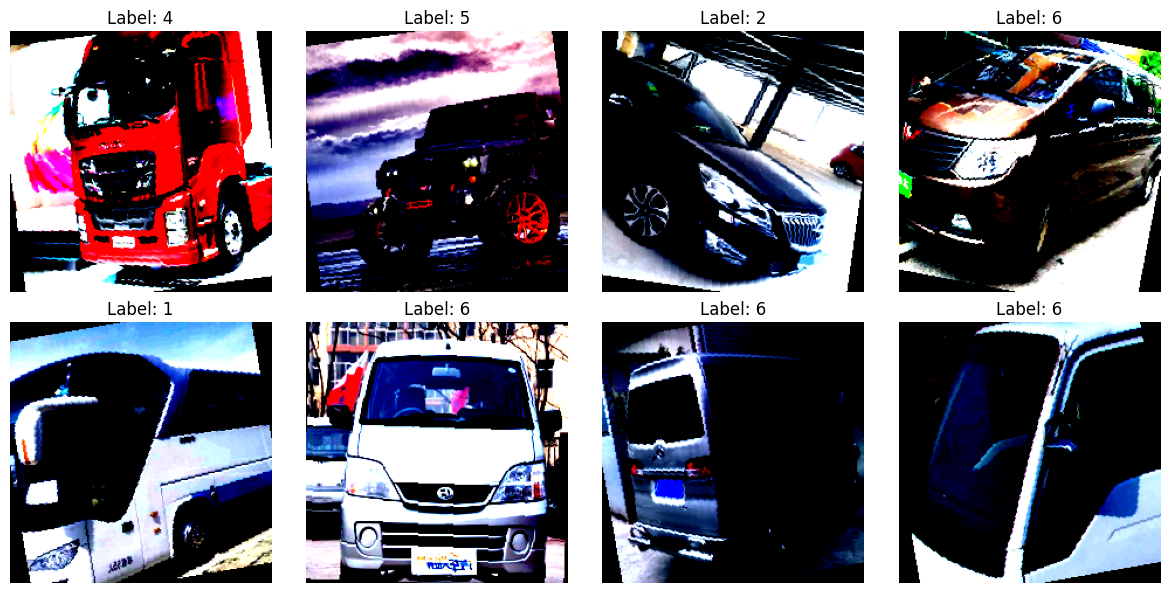

In [17]:
# Get the next batch of images and labels
images, labels = next(iter(train_loader))

images = images.permute(0, 2, 3, 1)  # Change shape from (8, C, H, W) to (8, H, W, C)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 rows, 4 columns

for i in range(8):
    ax = axes[i // 4, i % 4]
    ax.imshow(images[i].numpy())
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Creating and Downloading Model architectures

# Check Device Availability and Import Model Summary Tool
This cell determines whether a GPU (CUDA) is available for PyTorch operations and sets the appropriate device. It also imports torchsummary, a tool for summarizing the structure of PyTorch models.



In [18]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Creating a simple CNN model for comparison
This cell defines a custom convolutional neural network (CNN) class MyCNN for image classification tasks and uses the torchsummary library to display its architecture, including layer details and parameter counts.

In [19]:
class MyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MyCNN, self).__init__()
        
        # First convolution block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Second convolution block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Third convolution block
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Fourth convolution block
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Fully connected layers with dropout
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

my_model = MyCNN().to(device)

summary(my_model, (3, 224, 224), device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

### Downloading other model architectures and modifying the output fc layer

In [20]:
resnet = resnet50(weights=None).to(device)
resnet.fc = nn.Linear(resnet.fc.in_features, NUM_CLASSES).to(device)

vgg = vgg16(weights=None).to(device)
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, NUM_CLASSES).to(device)

mobilenet = mobilenet_v2(weights=None).to(device)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, NUM_CLASSES).to(device)

In [21]:
# Print model summaries
print("ResNet50 Summary:")
summary(resnet, (3, 224, 224), device=device.type)

print("\nVGG16 Summary:")
summary(vgg, (3, 224, 224), device=device.type)

print("\nMobileNetV2 Summary:")
summary(mobilenet, (3, 224, 224), device=device.type)

ResNet50 Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14 

# Model Dictionary for Experimentation
This cell creates a dictionary to store multiple models, including the custom model (my_model) and pretrained architectures (resnet, vgg16, mobilenet), for easy access and experimentation.



In [22]:
models = {
    'my_model': my_model,
    'resnet': resnet,
    'vgg16': vgg,
    'mobilenet': mobilenet
}

**Training the models**

In [23]:
# import shutil 
# shutil.rmtree("/kaggle/working/")

# Train a Deep Learning Model with Early Stopping and Mixed Precision
This cell defines the train_model function to train a deep learning model with various advanced techniques, including mixed precision training, a learning rate scheduler, and early stopping for optimization and performance.

In [24]:
def train_model(model, model_name, train_loader, val_loader, num_epochs=50):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Using AdamW optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    
    # Cosine Annealing scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    best_val_acc = 0.0
    patience = 10  # Increased patience
    patience_counter = 0
    
    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
    
    train_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Mixed precision training
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if batch_idx % 20 == 0:
                print(f'Epoch: {epoch+1} [{batch_idx * len(images)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)
        
        scheduler.step()
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, f'{model_name}_best.pth')
            patience_counter = 0
            print(f'New best model saved with validation accuracy: {val_acc:.2f}%')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break
    
    return train_losses, train_accs, val_accs


# Train and Evaluate Multiple Models with Training Curves
This cell iterates through the models dictionary, trains each model using the train_model function, and plots the training and validation metrics for visualization and comparison.




Training my_model...


<ipython-input-24-cb9cd0f22577>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
<ipython-input-24-cb9cd0f22577>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch: 1 [0/1400 (0%)]	Loss: 2.278564
Epoch: 1 [640/1400 (45%)]	Loss: 2.397640
Epoch: 1 [1280/1400 (91%)]	Loss: 4.137268
Epoch 1/50:
Train Loss: 8.0758, Train Acc: 11.36%
Val Loss: 2.6170, Val Acc: 14.50%
------------------------------------------------------------
New best model saved with validation accuracy: 14.50%
Epoch: 2 [0/1400 (0%)]	Loss: 3.348785
Epoch: 2 [640/1400 (45%)]	Loss: 2.329393
Epoch: 2 [1280/1400 (91%)]	Loss: 2.283020
Epoch 2/50:
Train Loss: 2.5596, Train Acc: 11.07%
Val Loss: 2.2074, Val Acc: 17.50%
------------------------------------------------------------
New best model saved with validation accuracy: 17.50%
Epoch: 3 [0/1400 (0%)]	Loss: 2.585144
Epoch: 3 [640/1400 (45%)]	Loss: 2.171028
Epoch: 3 [1280/1400 (91%)]	Loss: 2.333115
Epoch 3/50:
Train Loss: 2.2827, Train Acc: 14.00%
Val Loss: 2.1652, Val Acc: 18.50%
------------------------------------------------------------
New best model saved with validation accuracy: 18.50%
Epoch: 4 [0/1400 (0%)]	Loss: 2.275452
Ep

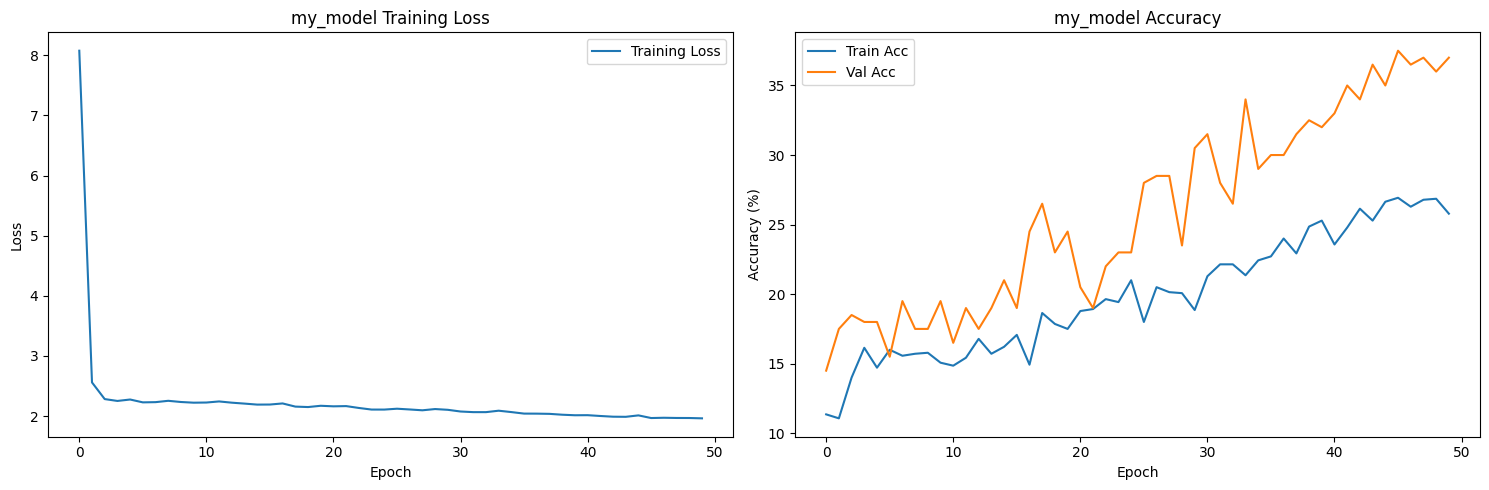


Training resnet...
Epoch: 1 [0/1400 (0%)]	Loss: 2.667664
Epoch: 1 [640/1400 (45%)]	Loss: 2.249512
Epoch: 1 [1280/1400 (91%)]	Loss: 2.427887
Epoch 1/50:
Train Loss: 2.6031, Train Acc: 13.50%
Val Loss: 13.7176, Val Acc: 23.00%
------------------------------------------------------------
New best model saved with validation accuracy: 23.00%
Epoch: 2 [0/1400 (0%)]	Loss: 2.298218
Epoch: 2 [640/1400 (45%)]	Loss: 2.345734
Epoch: 2 [1280/1400 (91%)]	Loss: 2.104164
Epoch 2/50:
Train Loss: 2.2550, Train Acc: 21.57%
Val Loss: 1.9759, Val Acc: 29.00%
------------------------------------------------------------
New best model saved with validation accuracy: 29.00%
Epoch: 3 [0/1400 (0%)]	Loss: 2.181683
Epoch: 3 [640/1400 (45%)]	Loss: 1.867123
Epoch: 3 [1280/1400 (91%)]	Loss: 1.830338
Epoch 3/50:
Train Loss: 2.0823, Train Acc: 25.86%
Val Loss: 1.9401, Val Acc: 33.50%
------------------------------------------------------------
New best model saved with validation accuracy: 33.50%
Epoch: 4 [0/1400 (0

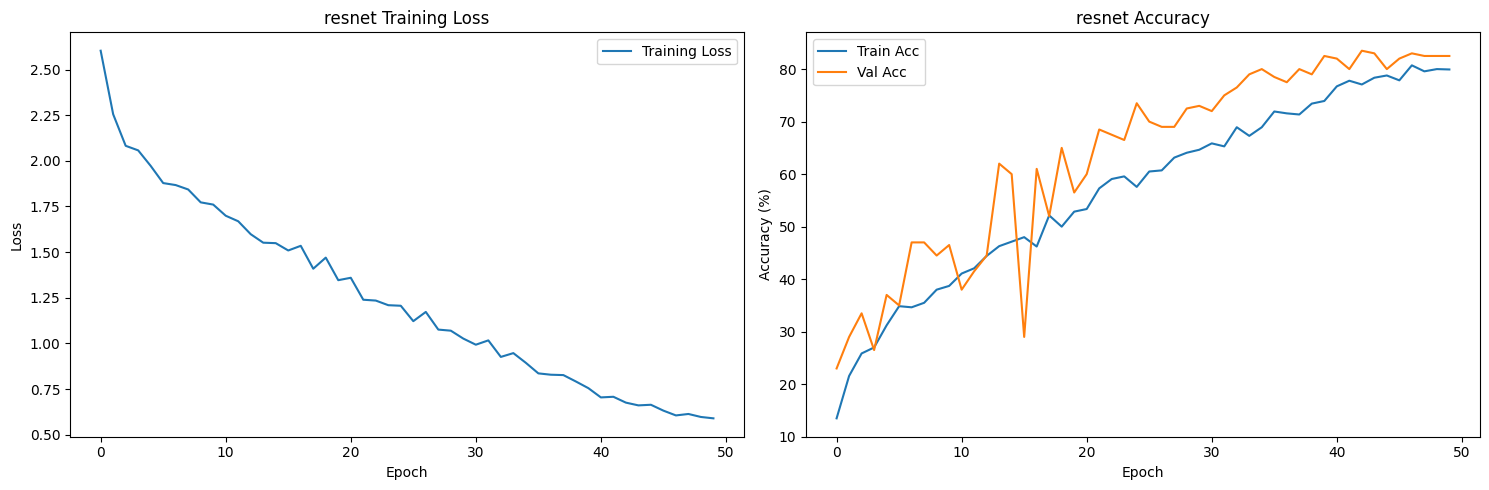


Training vgg16...
Epoch: 1 [0/1400 (0%)]	Loss: 2.304565
Epoch: 1 [640/1400 (45%)]	Loss: 2.303894
Epoch: 1 [1280/1400 (91%)]	Loss: 2.305847
Epoch 1/50:
Train Loss: 32.0514, Train Acc: 9.64%
Val Loss: 2.3015, Val Acc: 10.00%
------------------------------------------------------------
New best model saved with validation accuracy: 10.00%
Epoch: 2 [0/1400 (0%)]	Loss: 2.298584
Epoch: 2 [640/1400 (45%)]	Loss: 2.303833
Epoch: 2 [1280/1400 (91%)]	Loss: 2.299316
Epoch 2/50:
Train Loss: 2.3037, Train Acc: 9.86%
Val Loss: 2.3032, Val Acc: 10.00%
------------------------------------------------------------
Epoch: 3 [0/1400 (0%)]	Loss: 2.303955
Epoch: 3 [640/1400 (45%)]	Loss: 2.304749
Epoch: 3 [1280/1400 (91%)]	Loss: 2.304871
Epoch 3/50:
Train Loss: 2.3035, Train Acc: 10.07%
Val Loss: 2.3023, Val Acc: 10.00%
------------------------------------------------------------
Epoch: 4 [0/1400 (0%)]	Loss: 2.305847
Epoch: 4 [640/1400 (45%)]	Loss: 2.300354
Epoch: 4 [1280/1400 (91%)]	Loss: 2.303894
Epoch 4/5

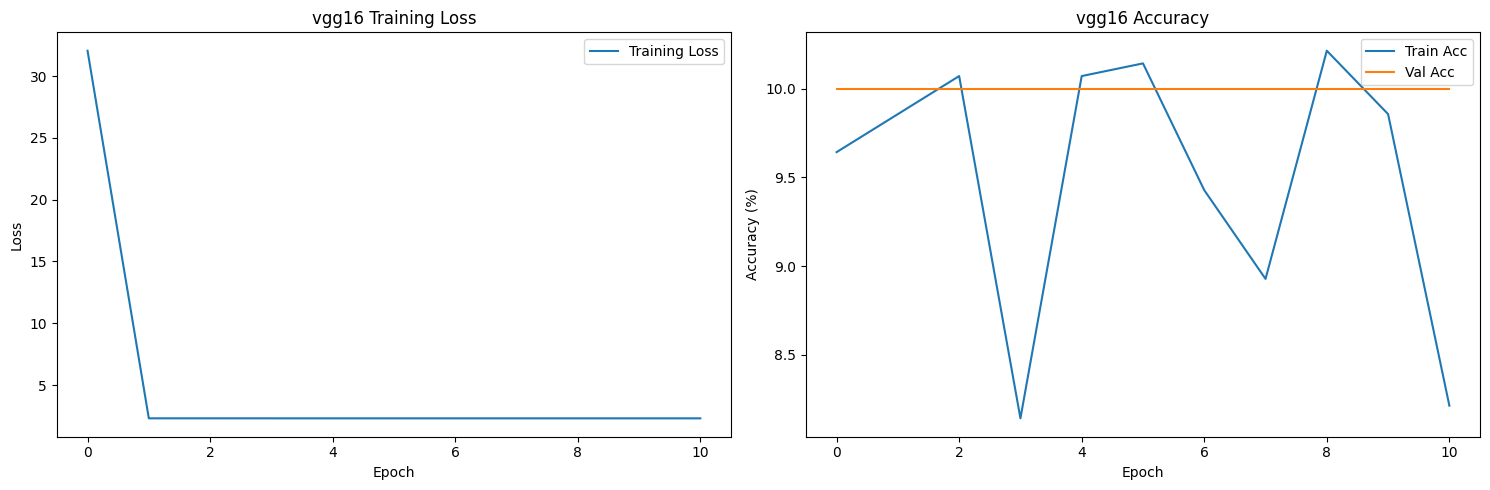


Training mobilenet...
Epoch: 1 [0/1400 (0%)]	Loss: 2.280884
Epoch: 1 [640/1400 (45%)]	Loss: 2.560089
Epoch: 1 [1280/1400 (91%)]	Loss: 2.003250
Epoch 1/50:
Train Loss: 2.2956, Train Acc: 15.21%
Val Loss: 2.6855, Val Acc: 10.00%
------------------------------------------------------------
New best model saved with validation accuracy: 10.00%
Epoch: 2 [0/1400 (0%)]	Loss: 2.344276
Epoch: 2 [640/1400 (45%)]	Loss: 2.072189
Epoch: 2 [1280/1400 (91%)]	Loss: 1.939484
Epoch 2/50:
Train Loss: 2.1132, Train Acc: 25.57%
Val Loss: 1.7997, Val Acc: 34.00%
------------------------------------------------------------
New best model saved with validation accuracy: 34.00%
Epoch: 3 [0/1400 (0%)]	Loss: 1.843536
Epoch: 3 [640/1400 (45%)]	Loss: 1.833969
Epoch: 3 [1280/1400 (91%)]	Loss: 1.983246
Epoch 3/50:
Train Loss: 1.9522, Train Acc: 30.86%
Val Loss: 1.7880, Val Acc: 38.50%
------------------------------------------------------------
New best model saved with validation accuracy: 38.50%
Epoch: 4 [0/1400 

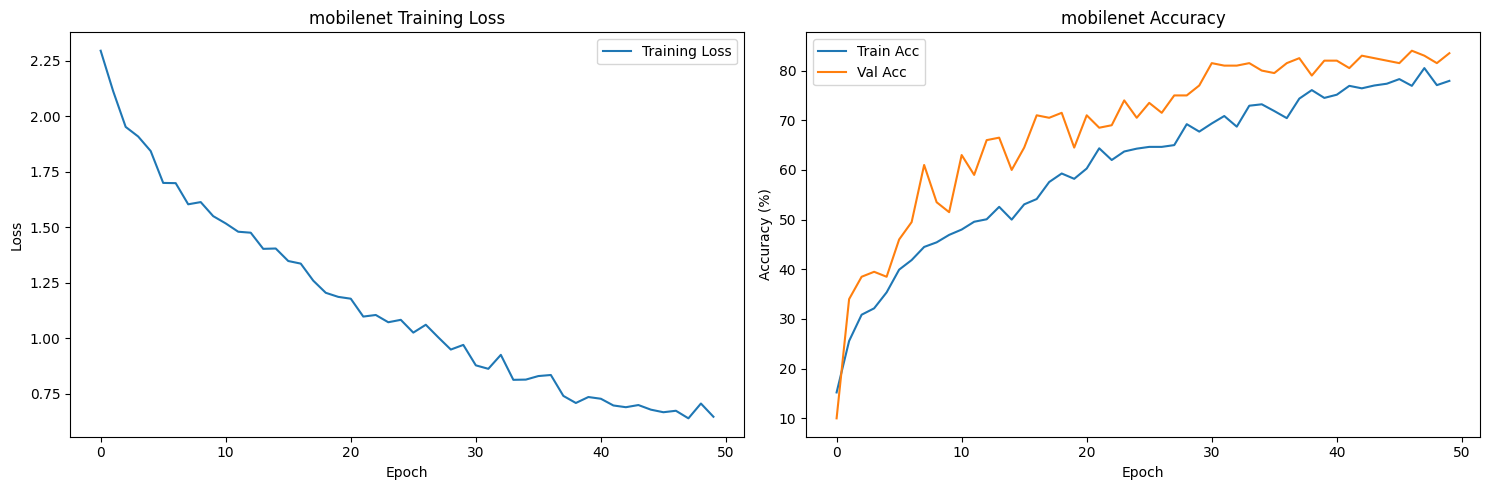

In [25]:
for name, model in models.items():
    print(f"\nTraining {name}...")
    print("=" * 60)
    train_losses, train_accs, val_accs = train_model(model, name, train_loader, val_loader)
    
    # Plot training curves
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title(f'{name} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{name}_training.png')
    plt.show()

# Testing

Predicted Class: SUV


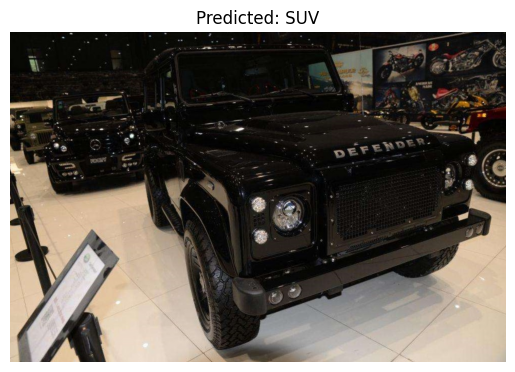

In [26]:
import os
from PIL import Image
from matplotlib import pyplot as plt

# Define class names
CLASS_NAMES = ['SUV', 'Bus', 'Family Sedan', 'Fire Engine', 'Heavy Truck', 
               'Jeep', 'Minibus', 'Racing Car', 'Taxi', 'Truck']

# Function to predict class of a given image
def predict_image(image_path, model, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = outputs.max(1)
    
    return class_names[predicted.item()]

# Example: Predicting class of a specific image from the dataset
test_image_path = "/kaggle/input/vehicle-classification/test/01ab0c4e74e5cefbc25e78e8b2b4b30d.jpg"  # Replace with the actual image path

# Predict the class
predicted_class = predict_image(test_image_path, my_model, CLASS_NAMES)
print(f"Predicted Class: {predicted_class}")

# Optional: Visualize the prediction
image = Image.open(test_image_path).convert('RGB')
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()


Predicted Class: Heavy Truck


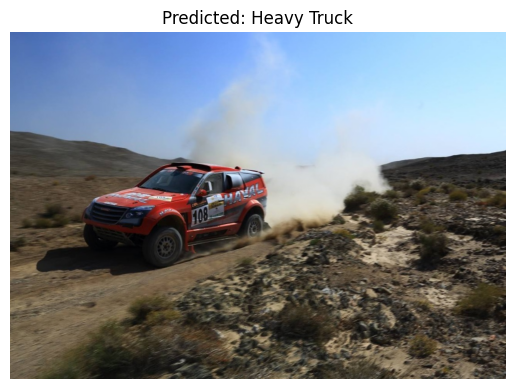

In [27]:
import os
from PIL import Image
from matplotlib import pyplot as plt

# Define class names
CLASS_NAMES = ['SUV', 'Bus', 'Family Sedan', 'Fire Engine', 'Heavy Truck', 
               'Jeep', 'Minibus', 'Racing Car', 'Taxi', 'Truck']

# Function to predict class of a given image
def predict_image(image_path, model, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = outputs.max(1)
    
    return class_names[predicted.item()]

# Example: Predicting class of a specific image from the dataset
test_image_path = "/kaggle/input/vehicle-classification/test/02a43a441f5c71ab9ff8ecab1f33ca49.jpg"  # Replace with the actual image path

# Predict the class
predicted_class = predict_image(test_image_path, my_model, CLASS_NAMES)
print(f"Predicted Class: {predicted_class}")

# Optional: Visualize the prediction
image = Image.open(test_image_path).convert('RGB')
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()



In [28]:
kaggle kernels output arslan750/vehicle-type-classification 

SyntaxError: invalid syntax (<ipython-input-28-bee37df0dae0>, line 1)